<a href="https://colab.research.google.com/github/wheemin-2/25-1-ESAA/blob/main/0509_HW_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **파이토치 기초**

파이토치를 활용한 간단한 분류 및 회귀 모델 구현 연습

car_evaluation 데이터 사용
- feature : price, maint(유지 비용), doors(문 개수), persons(수용 인원), lug_capacity(수하물 용량), safety(안정성)
- target : output(차 상태)
    - unacc(허용 불가능한 수준)부터 very good(매우 좋은) 까지의 값을 가짐

In [1]:
# 필요한 라이브러리 호출
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# 데이터 로드
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/25-1 OB/car_evaluation.csv')
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


<Axes: ylabel='count'>

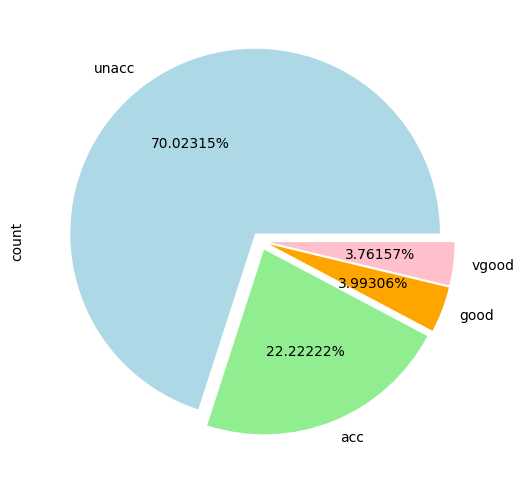

In [4]:
# target의 분포 확인
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams['figure.figsize'] = fig_size
dataset.output.value_counts().plot(kind='pie', autopct='%0.05f%%',
                                   colors=['lightblue','lightgreen','orange','pink'],
                                   explode=(0.05,0.05,0.05,0.05))

대부분의 자동차(70%)는 허용 불가능한 상태(unacc), 20%만 허용이 가능한 수준임. 즉, 양호한 상태의 자동차 비율이 매우 낮음

## **데이터 전처리**

### **범주형 데이터 > 텐서 변환**

딥러닝은 통계 알고리즘을 기반으로 하기 때문에 단어를 숫자(텐서)로 변환해야 함

**범주형 데이터를 텐서로 변환하기 위한 과정**

: 범주형 데이터 > dataset[category] > NumPy array > Tensor

- 파이토치로 모델을 학습시키기 위해서는 텐서 형태로 변환해야 하는데, 넘파이 배열을 통해 텐서를 생성할 수 있음
- `cat.codes` : 범주형 데이터(단어)를 숫자(넘파이 배열)로 변환하기 위해 사용
    - 어떤 클래스가 어떤 숫자로 매핑되어있는지 확인하기 어려우므로 사용에 주의
    

In [5]:
# 범주 특성을 갖는 데이터를 범주형 타입으로 변환 (astype 메서드)
categorical_columns = ['price','maint','doors','persons','lug_capacity','safety']

for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

# 범주형 데이터를 넘파이 배열(숫자)로 변환(cat.codes)
price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

# stack (1차원 배열이 모여 2차원이 됨)
categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety],axis=1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

**np.stack vs. np.concatenate**

: 넘파이 객체를 합칠 때 사용하는 메서드, 차이점은 차원의 유지 여부!

[np.concatenate]
- 선택한 축을 기준으로 배열을 연결함
 ![concat1](https://thebook.io/img/080289/073_1.jpg)
 ![concat2](https://thebook.io/img/080289/073_2.jpg)

[np.stack]
- 새로운 축으로 배열을 합침
    - 1차원 배열을 합쳐서 2차원 배열을 생성하거나 2차원 배열을 합쳐서 3차원 배열을 생성
    - 반드시 두 배열의 차원이 동일해야 함
 ![stack1](https://thebook.io/img/080289/074_1.jpg)
 ![stack2](https://thebook.io/img/080289/074_2.jpg)

In [6]:
# 배열을 텐서로 변환
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [7]:
# target 변수도 텐서로 변환 (get_dummies 이용)
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten() # 1차원 텐서로 변환

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


*(참고) 텐서의 차원을 바꿔주는 함수* : `ravel()`, `reshape()`, `flatten()`

### **워드 임베딩**

Embedding : 단어를 벡터로 바꿔주는 과정

- 컴퓨터는 인간의 언어인 단어를 인식할 수 없기 때문에 임베딩 처리가 필요함

워드 임베딩 : 유사한 단어끼리 유사하게 인코딩되도록 표현하는 방법
- 높은 차원의 임베딩일수록 단어 간의 세부적인 관계를 잘 파악할 수 있음
- 따라서 단일 숫자로 변환된 넘파이 배열을 N차원으로 변경하여 사용

임베딩 크기(= 벡터 차원)
- 배열을 N차원으로 변환하기 위해서는 먼저 모든 범주형 칼럼에 대한 임베딩 크기를 정의해야함
- 정확한 규칙은 없으나 대체로 $(칼럼의 고유 값 수) / 2$  를 사용
    - ex. price : 4개의 고유값을 가짐 > 임베딩 크기 2

In [8]:
# 범주형 칼럼을 N차원으로 변환
categorical_column_sizes = [len(dataset[column].cat.categories) for column
                            in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size
                               in categorical_column_sizes]

# (각 범주형 칼럼의 고유값 수, 임베딩 크기) 출력
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


### **데이터셋 분리**

In [9]:
total_records = 1728
test_records = int(total_records * 0.2) # 20%를 테스트 용도로 사용

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]
train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records:total_records]

In [10]:
# 데이터셋 분리 확인
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


## **모델 네트워크 생성**

In [11]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni,
                                             nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        all_layers=[]
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        # 입력층의 크기를 찾기 위해 범주형 칼럼의 개수를 input_size 변수에 저장
        input_size = num_categorical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size=i

        all_layers.append(nn.Linear(layers[-1], output_size))
        # 신경망의 모든 계층이 순차적으로 실행되도록
        # 모든 계층에 대한 목록(all_layers)를 nn.Sequential 클래스로 전달
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical):
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1) # 넘파이의 concatenate와 기능 동일
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

[class 내 함수 설명]

1. __init __ () : 모델에서 사용될 파라미터와 신경망을 초기화하기 위한 용도로 사용하며， 객체가 생성될 때 자동으로 호출됨


- 모델의 네트워크 계층을 구축하기 위해 for 문을 이용하여 각 계층을 all_layers 목록에 추가

[추가된 계층 설명]

- Linear: 선형 계층(linear layer)은 입력 데이터에 선형 변환을 진행한 결과
    
선형 변환 수식 : $y = Wx + b$,      
$(W: 가중치, x: 입력 값, b: bias)$

- ReLU: 활성화 함수로 사용

- BatchNorm1d: 배치 정규화(batch normalization) 용도로 사용

- Dropout: 과적합 방지에 사용

2. forward() 함수 : 학습 데이터를 입력받아 연산을 진행

In [12]:
# Model 클래스의 객체 생성
model = Model(categorical_embedding_sizes, 4, [200,100,50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


## **모델 파라미터 정의 / 모델 학습**

모델을 훈련시키기 전, 손실 함수와 옵티마이저에 대한 정의가 필요
- 분류 문제에서는 'cross entropy' 손실 함수 사용
- 옵티마이저로는 'Adam' 사용

In [13]:
# 모델 파라이터 정의
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
# CPU/GPU 사용 지정
# GPU가 있다면 GPU 사용, 없다면 CPU 사용하게 하는 코드
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [15]:
# 모델 학습
epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss) # 반복할 때마다 오차를 추가

    if i%25 == 1 :
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()  #가중치 업데이트
    optimizer.step()  # 기울기 업데이트

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 1.62586248
epoch:  26 loss: 1.41969490
epoch:  51 loss: 1.30866015
epoch:  76 loss: 1.22455084
epoch: 101 loss: 1.08296144
epoch: 126 loss: 0.94726014
epoch: 151 loss: 0.83011556
epoch: 176 loss: 0.76562113
epoch: 201 loss: 0.69569778
epoch: 226 loss: 0.66717011
epoch: 251 loss: 0.64390785
epoch: 276 loss: 0.61597323
epoch: 301 loss: 0.61584204
epoch: 326 loss: 0.60774684
epoch: 351 loss: 0.59099460
epoch: 376 loss: 0.58518410
epoch: 401 loss: 0.58948720
epoch: 426 loss: 0.58509225
epoch: 451 loss: 0.57381028
epoch: 476 loss: 0.57458013
epoch: 500 loss: 0.5759720802


## **모델 예측**

In [22]:
test_outputs = test_outputs.to(device=device, dtype=torch.int64)
with torch.no_grad():
    y_val = model(categorical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.57382125


In [23]:
# 모델 예측 확인
# 모델 객체 생성 시 output_size=4로 지정했음
print(y_val[:5])

tensor([[ 2.8328,  1.6403, -3.2914, -3.3046],
        [ 2.0942,  1.2864, -3.4191, -3.1065],
        [ 2.6351,  1.4472, -3.3410, -3.3011],
        [ 3.0182,  1.5282, -4.0466, -3.9451],
        [ 2.8849,  1.7360, -3.6782, -3.4237]])


In [24]:
# 각 행에서 가장 큰 값을 갖는 인덱스 확인 (정답 레이블과 비교)
y_val = np.argmax(y_val, axis=1)
print(y_val[:5])
# 정답
test_outputs[:5]

tensor([0, 0, 0, 0, 0])


tensor([0, 0, 0, 1, 0])

In [25]:
# 테스트 데이터셋을 이용한 정확도 확인
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(test_outputs, y_val))
print(classification_report(test_outputs, y_val))
print(accuracy_score(test_outputs, y_val))

[[258   1]
 [ 86   0]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       259
           1       0.00      0.00      0.00        86

    accuracy                           0.75       345
   macro avg       0.38      0.50      0.43       345
weighted avg       0.56      0.75      0.64       345

0.7478260869565218


*모델 평가 지표*

1. 정확도

- 전체 예측 건수에서 정답을 맞힌 건수의 비율. 이때 맞힌 정답이 긍정(positive)인지, 부정(negative)인지는 상관없음.

 ![accuracy](https://thebook.io/img/080289/fn-12.jpg)

2. 재현율
- 실제로 정답이 1이라고 할 때 모델(분류기)도 1로 예측한 비율. 따라서 처음부터 데이터가 1일 확률이 적을 때 사용하면 좋음
 ![recall](https://thebook.io/img/080289/fn-13.jpg)

3. 정밀도
- 모델(분류기)이 1이라고 예측한 것 중에서 실제로 정답이 1인 비율

 ![precision](https://thebook.io/img/080289/fn-14.jpg)

4. f1-score
- 정밀도와 재현율의 트레이드오프 문제를 해결하기 위해 정밀도와 재현율의 조화 평균을 이용한 지표

 ![f1 score](https://thebook.io/img/080289/fn-15.jpg)
